In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/Bayes

/gdrive/My Drive/Bayes


In [3]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [4]:
def build_beta(beta_b, b, kd, p):
  beta = np.array(beta_b)
  beta = np.insert(beta, b-1, -np.sum([beta_b[i] for i in range(p-1)]))
  for i in range(kd):
    beta = np.insert(beta, int(p+i+(b-1)*kd), -np.sum([beta_b[(p-1)+j*kd+i] for j in range(p-1)]))
  return beta

In [5]:
def build_beta_b(beta, b, kd, p):
  indices = [b-1]
  for i in range(p + (b-1)*kd, p + b*kd):
    indices.append(i)
  
  beta_b = np.delete(beta, indices)
  return beta_b

In [6]:
def sample_fullcond_beta(X, Y, p, n, kd, W_tilda, b, sigma_b, alpha, A):
  indices = [b-1]
  for i in range(p + (b-1)*kd, p + b*kd):
    indices.append(i)

  X_b = np.delete(X, indices, axis=1)
  X_b = np.delete(X_b, [i for i in range(b-1, p*n, p)], axis=0)
  W_b_tilda = np.delete(W_tilda, b-1, 0)

  beta_hat_1 = np.dot(np.dot(np.transpose(X_b[0:(p-1),:]) , inv(sigma_b)) , X_b[0:(p-1),:])
  beta_hat_2 = np.dot(np.dot(np.transpose(X_b[0:(p-1),:]) , inv(sigma_b)) , W_b_tilda[:,0])
  for i in range(1,n-1):
    beta_hat_1 += np.dot(np.dot(np.transpose(X_b[i*(p-1):(i+1)*(p-1),:]) , inv(sigma_b)) , X_b[i*(p-1):(i+1)*(p-1),:])
    beta_hat_2 += np.dot(np.dot(np.transpose(X_b[i*(p-1):(i+1)*(p-1),:]) , inv(sigma_b)) , W_b_tilda[:,i])

  beta_hat = np.dot(inv(beta_hat_1+inv(A)) , beta_hat_2)
  beta_tilda_b = np.random.multivariate_normal(beta_hat, (alpha**2) * inv(beta_hat_1+inv(A)))

  return build_beta(beta_tilda_b, b, kd, p)   

In [7]:
def eval_prob(X, nu_b, S_b, beta_tilda, W_tilda, n, b, p, kd):
  indices = [b-1]
  for i in range(p + (b-1)*kd, p + b*kd):
    indices.append(i)

  W_tilda_b = np.delete(W_tilda, b-1, 0)
  X_b = np.delete(X, indices, axis=1)
  X_b = np.delete(X_b, [i for i in range(b-1, p*n, p)], axis=0)

  beta_tilda_b = build_beta_b(beta_tilda, b, kd, p)

  sum = np.outer(W_tilda_b[:,0] - np.dot(X_b[0:(p-1),:],beta_tilda_b) , W_tilda_b[:,0] - np.dot(X_b[0:(p-1),:],beta_tilda_b))
  for i in range(1,n-1):
    sum += np.outer(W_tilda_b[:,i] - np.dot(X_b[i*(p-1):(i+1)*(p-1),:],beta_tilda_b) , W_tilda_b[:,i] - np.dot(X_b[i*(p-1):(i+1)*(p-1),:],beta_tilda_b))

  return (-0.5*(n+nu_b))*np.log(np.linalg.det(S_b + sum))

In [32]:
def sample_fullcond_b(X, nu_b, S_b, beta_tilda, W_tilda, n, b_old, p, kd):
  probs = []
  for i in range(p):
    probs.append(eval_prob(X, nu_b, S_b, beta_tilda, W_tilda, n, i+1, p, kd))
  probs = sp.special.softmax(probs)
  # print(probs)

  b = np.argmax(np.random.multinomial(1, probs)) + 1
  # print(b)
  return b

In [10]:
def sample_fullcond_others(X, Y, nu_b, S_b, p, n, b, beta_tilda, W_tilda):
  b_old = b
  b = sample_fullcond_b(X, nu_b, S_b, beta_tilda, W_tilda, n, b_old, p, kd)

  indices = [b-1]
  for i in range(p + (b-1)*kd, p + b*kd):
    indices.append(i)

  X_b = np.delete(X, indices, axis=1)
  X_b = np.delete(X_b, [i for i in range(b-1, p*n, p)], axis=0)
  W_tilda_b = np.delete(W_tilda, b-1, 0)
  beta_tilda_b = build_beta_b(beta_tilda, int(b), kd, p)

  sum = np.outer(W_tilda_b[:,0] - np.dot(X_b[0:(p-1),:],beta_tilda_b) , W_tilda_b[:,0] - np.dot(X_b[0:(p-1),:],beta_tilda_b))
  for i in range(1,n-1):
    sum += np.outer(W_tilda_b[:,i] - np.dot(X_b[i*(p-1):(i+1)*(p-1),:],beta_tilda_b) , W_tilda_b[:,i] - np.dot(X_b[i*(p-1):(i+1)*(p-1),:],beta_tilda_b))

  sigma_tilda_b = np.array(sp.stats.invwishart.rvs(df=n+nu_b, scale=S_b+sum))
  alpha = np.sqrt(np.trace(sigma_tilda_b)/(p-1))
  sigma_b = sigma_tilda_b/alpha**2
  return alpha, sigma_b, b

In [11]:
def sample_fullcond_W(Y, X, p, n, kd, W_tilda, beta_tilda, b, sigma_b, alpha, r, m):
    ### following Albert and Chib strategy (1993) we can sample from a Normal for each Wij and then discard the draw if the conditions that we must impose
    ### are not satisfied; otherwise keep the result and store it
    indices = [b-1]
    for i in range(p + (b-1)*kd, p + b*kd):
      indices.append(i)
    
    X_b = np.delete(X, indices, axis=1)
    X_b = np.delete(X_b, [i for i in range(b-1, p*n, p)], axis=0)
    row_b = W_tilda[b-1,:]
    W_b_tilda = np.delete(W_tilda, b-1, 0)
    beta_b_tilda=build_beta_b(beta_tilda, b, kd, p)

    sigma_tilda_b = alpha**2 * sigma_b

    for i in range(n):
      for j in range(p-1):
        sigma_tilda_b_j = np.delete(np.delete(sigma_tilda_b, j, axis=0), j, axis=1) #matrice senza righe e colonne j
        sig__jj = np.delete(sigma_tilda_b[:,j], j) #colonna j senza elemento j
        sig_j_j = np.delete(sigma_tilda_b[j,:], j) #riga j senza elemento j
        F = np.dot(inv(sigma_tilda_b_j),sig__jj)
        X_i = X_b[[k for k in range((p-1)*i, (p-1)*(i+1))],:]
        xij = X_i[j,:]
        X_i_j = np.delete(X_i, j, axis=0)
        W_i_j = np.delete(W_b_tilda[:,i], j)
        
        mean = np.dot(xij, beta_b_tilda) + np.dot(F, (W_i_j - np.dot(X_i_j, beta_b_tilda)))
        var = sigma_tilda_b[j,j] - np.dot(np.dot(sig_j_j,inv(sigma_tilda_b_j)),sig__jj)
        
        Yi = Y[i]-1
        proposal=np.random.normal(mean, var)
        
        if Yi == j and Yi != (b-1):
          if(proposal > -0.5*np.sum(W_i_j) and proposal > np.max(W_i_j)):
            W_b_tilda[j,i] = proposal
            r[0]+=1
          m[0]+=1
        
        if Yi != j and Yi != (b-1):
          if(proposal < W_tilda[Yi,i] and proposal > -np.sum(W_b_tilda[:,i]) - W_tilda[Yi,i]):
            W_b_tilda[j,i] = proposal
            r[1]+=1
          m[1]+=1
        
        if Yi == (b-1):
          if(proposal < min(-0.5*np.sum(W_i_j), -1*(np.max(np.delete(W_b_tilda,j,axis=0)) + np.sum(W_i_j)))):
            W_b_tilda[j,i] = proposal
            r[2]+=1
          m[2]+=1
    
    W_tilda = np.insert(W_b_tilda, b-1, row_b, axis=0)

    return W_tilda, r, m

In [29]:
def run_mcmc(X, Y, p, n, kd, ka, niter=6000, nburn=1000, thin=5):
    W = np.zeros(p)
    for i in range(n):
        W_i = np.random.multivariate_normal(np.zeros(p), np.eye(p))
        W_i[Y[i]-1], W_i[np.argmax(W_i)] = W_i[np.argmax(W_i)], W_i[Y[i]-1]
        W = np.column_stack((W,W_i))
    W = np.delete(W, 0, axis=1)

    k = (p-1)*(kd+1)+ka
    A = sp.stats.invwishart.rvs(df=k+4, scale=(k+4)*np.eye(k))   # see McCulloch & Rossi
    # A = np.eye((p-1)*(kd+1)+ka)   # identity matrix
    b = int(np.random.randint(1,p+1,1))
    # print(b)
    
    nu_b = p+1
    c = 1/(p-1)
    S_b = np.diag((1+c)*np.ones(p-1)) - c*np.ones((p-1,p-1))
    alpha = 1
    sigma_b = sp.stats.invwishart.rvs(df=nu_b, scale=S_b, size=1) ### pensare se fissare traccia a p-1

    ### beta from a normal(0,A)
    beta_b = np.random.multivariate_normal(np.zeros((p-1)*(kd+1)+ka), A)
    beta = build_beta(beta_b, b, kd, p)
      
    W_tilda = alpha*W
    beta_tilda = alpha*beta
    out_W = np.empty([p,n])
    out_alpha = []
    out_beta1 = []
    out_w1 = []

    ### indeces to check the acceptance ratios in the sample of W
    r = [0,0,0]
    m = [0,0,0]

    for i in range(niter):
        if i % thin == 0:
            print("Iter: {0} / {1} \n".format(i+1, niter), flush=True)

        W_tilda, r, m = sample_fullcond_W(Y, X, p, n, kd, W_tilda, beta_tilda, b, sigma_b, alpha, r, m)
        beta_tilda = sample_fullcond_beta(X, Y, p, n, kd, W_tilda, b, sigma_b, alpha, A)
        alpha, sigma, b = sample_fullcond_others(X, Y, nu_b, S_b, p, n, b, beta_tilda, W_tilda)
        # print(alpha)

        if(alpha > 100):
          break
           
        if i > nburn and i % thin == 0:
            out_W = np.concatenate((out_W,np.array(W_tilda/alpha)), axis=0)
            out_alpha.append(alpha)
            out_beta1.append(beta_tilda[0])
            out_w1.append(W_tilda[3,4])

    print('acceptance ratios: ', r[0]/m[0], r[0], m[0])  
    print(r[1]/m[1], r[1], m[1])    
    print(r[2]/m[2], r[2], m[2])
    figs, axs = plt.subplots(3, 1, figsize=(17,17))
    axs[0].plot(out_alpha)
    axs[1].plot(out_beta1)
    axs[2].plot(out_w1)

    return out_W

Iter: 1 / 6000 

Iter: 6 / 6000 

Iter: 11 / 6000 

Iter: 16 / 6000 

Iter: 21 / 6000 

Iter: 26 / 6000 

Iter: 31 / 6000 

Iter: 36 / 6000 

Iter: 41 / 6000 

Iter: 46 / 6000 

Iter: 51 / 6000 

Iter: 56 / 6000 

Iter: 61 / 6000 

Iter: 66 / 6000 

Iter: 71 / 6000 

Iter: 76 / 6000 

Iter: 81 / 6000 

Iter: 86 / 6000 

Iter: 91 / 6000 

Iter: 96 / 6000 

Iter: 101 / 6000 

Iter: 106 / 6000 

Iter: 111 / 6000 

Iter: 116 / 6000 

Iter: 121 / 6000 

Iter: 126 / 6000 

Iter: 131 / 6000 

Iter: 136 / 6000 

Iter: 141 / 6000 

Iter: 146 / 6000 

Iter: 151 / 6000 

Iter: 156 / 6000 

Iter: 161 / 6000 

Iter: 166 / 6000 

Iter: 171 / 6000 

Iter: 176 / 6000 

Iter: 181 / 6000 

Iter: 186 / 6000 

Iter: 191 / 6000 

Iter: 196 / 6000 

Iter: 201 / 6000 

Iter: 206 / 6000 

Iter: 211 / 6000 

Iter: 216 / 6000 

Iter: 221 / 6000 

Iter: 226 / 6000 

Iter: 231 / 6000 

Iter: 236 / 6000 

Iter: 241 / 6000 

Iter: 246 / 6000 

Iter: 251 / 6000 

Iter: 256 / 6000 

Iter: 261 / 6000 

Iter: 266 / 600

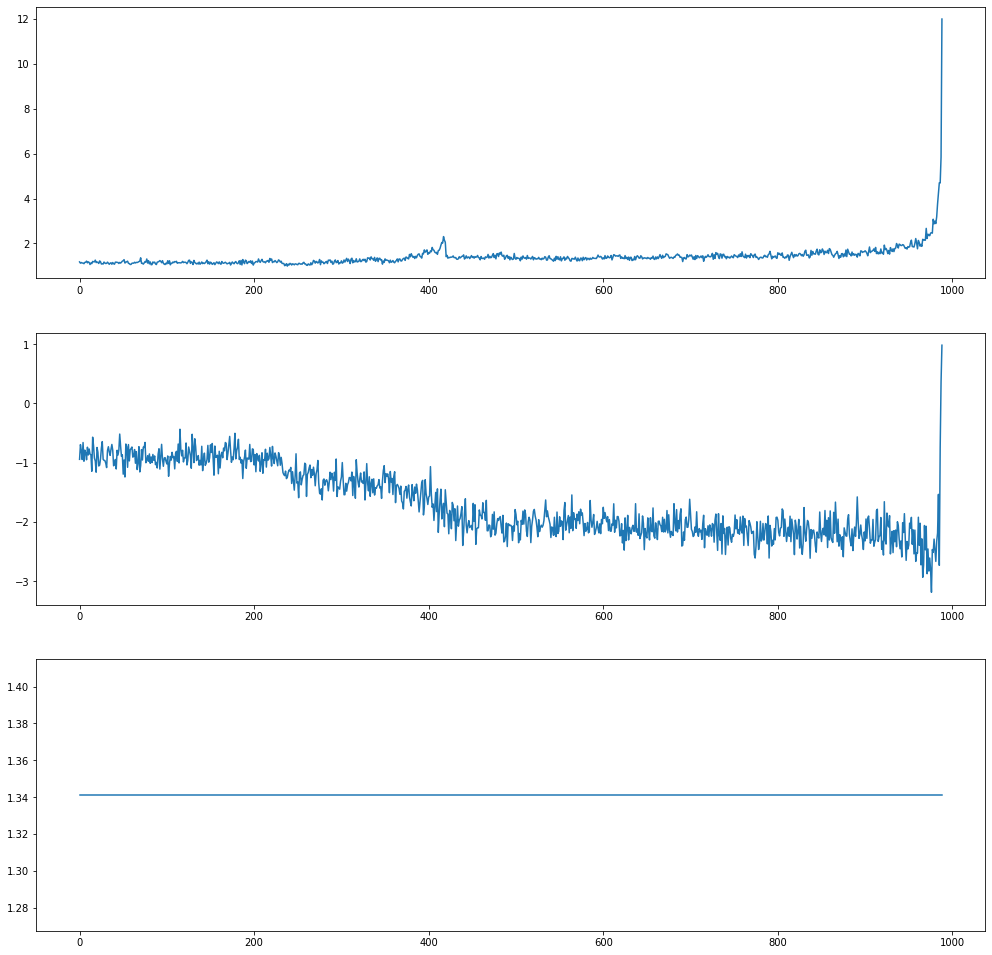

In [34]:
### MAIN ###

# set the seed
np.random.seed(54)

# load data
X = pd.read_csv('X_i.csv')

# impose right shape of data
X = np.array(X)
agents_indices = X[:,0]
X = np.delete(X, 0, axis=1)
X = X[600:1200,:]
# beta = np.array(beta)

# define parameters
p = 6   # number of categories
n = 100   # number of agents
kd = 1   # agent specific covariates
ka = 1   # alternative specific covariates
niter = 6000
nburn = 1000
thin = 5

Y = X[[k for k in range(0,p*n, p)],-1].astype(int)
X = np.delete(X, -1, axis=1)

# call run_mcmc
out = run_mcmc(X, Y, p, n, kd, ka, niter, nburn, thin)

# extract category chosen by agents
utilities = np.zeros([p,n])
iter = out.shape[0]/p
util = np.zeros(n)

for i in range(int(iter)):
  util = np.argmax(out[i*p:(i+1)*p,:],axis=0)
  for j in range(n):
    utilities[util[j],j] = utilities[util[j],j]+1
probabilities = utilities/iter
preferences = np.argmax(utilities,axis=0)+1
print(sum(preferences==Y))